# Getting started with JAX and DALI

This tutorial shows how to use DALI with JAX. You will learn how to use DALI as a data source for JAX workflows, how to use GPU to accelerate data preprocessing and how to scale up your training with multi-GPU.

### Prerequisites

This tutorial assumes that you have already installed DALI and JAX with GPU support. If you haven't done so, please follow the [DALI installation guide](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/installation.html) and [JAX installation guide](https://jax.readthedocs.io/en/latest/installation.html).

Test data used for this example can be found in [DALI Github page](https://github.com/NVIDIA/DALI/tree/main/docs/examples/data/images).


In [1]:
image_dir = "../../data/images"

### Quick start

The code below is a simple and ready to copy example of how to use DALI with JAX. The following sections will go through it step by step and explain how it works.


In [2]:
import nvidia.dali.fn as fn
from nvidia.dali.plugin.jax import data_iterator

@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels

iterator = iterator_fn(batch_size=8)

batch = next(iterator)  # batch of data ready to be used by JAX


### Running DALI with JAX

In DALI, the main concept that you need to get accustomed to is the `Pipeline`. It is a graph of operations that are executed asynchronously with regards to the main Python thread. The `Pipeline` is defined in Python, but the execution is done in C++, which makes it fast and efficient. Computations defined as parts of a `Pipeline` can be executed on the CPU or the GPU.

We start by defining a pipeline function. Here we declare how the graph of operetions will look like. In this starting example we use operations from `nvidia.dali.fn` module. This module contains all the basic operations that are available in DALI:

In [3]:
import nvidia.dali.fn as fn


def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs)
    images = fn.resize(images, resize_x=256, resize_y=256)

    return images, labels

This function defines the following preprocessing pipline:
 - read raw JPEGs and labels from the storage
 - decode JPEGs to RGB format
 - resize decoded images to 256x256 
 
 Even though it is very simple it can serve as a good approximation of the usual preprocessing pipeline that is used in many computer vision tasks. The only difference is that we do not apply any augmentations here. We will cover how to apply augmentations in one of the following sections.

 Above we defined the graph of operations. Now we need to run it in a JAX context. DALI provides simple to use decorator to transform pipeline definition function.

In [4]:
from nvidia.dali.plugin.jax import data_iterator

This decorator can be used to create a function that will produce data iterators compatible with JAX. Decorator accepts arguments to control the final iterator. For now we will focus on:
 - pipeline function to transform,
 - `output_map` - a list of names for the outputs that will be used in JAX,
 - `reader_name` - a name of the reader operator that will be used to read data from the storage.

In [5]:
iterator_fn = data_iterator(
    simple_pipeline,
    output_map=["images", "labels"],
    reader_name="image_reader")

Note, how the `reader_name` value is the same as the `name` value used for the `fn.readers.file` operator in the pipeline function. It tells the iterator which operator is used to read the data from the storage and should be queried for the number of samples in the dataset.

`iterator_fn` is a function that will produce data iterators. It can be used to create multiple iterators that will iterate over the same dataset. This is useful when you want to reuse some code for training and validation pipelines. Applying the decorator adds some additional arguments to the function. One of them is `batch_size` used to control the number of samples per batch of data be produced by the iterator:


In [6]:
iterator = iterator_fn(batch_size=1)

We can use the iterator to get data. The iterator returns a dictionary with the keys defined in the `output_map` argument. The values are JAX arrays.

In [7]:
output = next(iterator)

print(output.keys())

print(type(output["images"]))
print(output['images'].shape)

print(type(output["labels"]))
print(output['labels'].shape)

dict_keys(['images', 'labels'])
<class 'jaxlib.xla_extension.ArrayImpl'>
(1, 256, 256, 3)
<class 'jaxlib.xla_extension.ArrayImpl'>
(1, 1)


To visualize the outputs we create a simple function to print the images using matplotlib:

In [8]:
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image)

We can now use it to inspect the content of the output:

Label = [0]


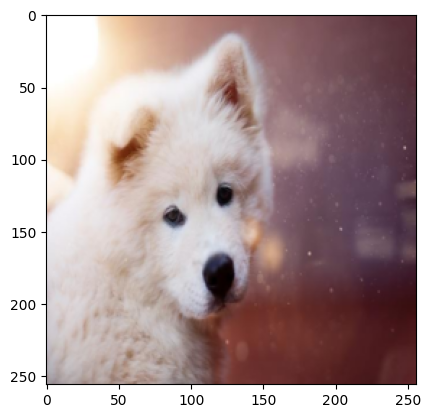

In [9]:
image = output["images"]
show_image(image[0])

print(f'Label = {output["labels"][0]}')

We can continue to run the iterator and get the next batch:

Label = [0]


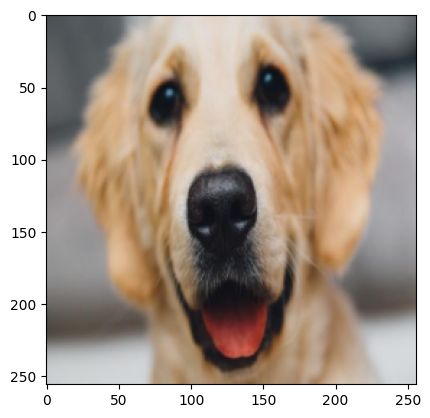

In [10]:
output = next(iterator)

image = output["images"]
show_image(image[0])

print(f'Label = {output["labels"][0]}')

Note that the `data_iterator` can be used in a declarative way as well. Since this is a more condensed way to express the same thing we will use it in the following sections:

In [11]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs)
    images = fn.resize(images, resize_x=256, resize_y=256)

    return images, labels

iterator = iterator_fn(batch_size=1)

Iterator is comatible with Python `__iter__` protocol. It can be used in `for` loops or with `next` function. It is also compatible with `len` function. `len` returns the number of batches in the dataset.

In [12]:
iterator = iterator_fn(batch_size=1)
print(f'Iterator size: {len(iterator)}')

for batch_id, batch in enumerate(iterator):
    print(batch_id)

Iterator size: 21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


### Batching

For now we returned only one sample per iteration or `next` call. Note that the returned arrays had a leading dimension of size 1. This is because the iterator returns a batch of data. The size of the batch is controlled by the `batch_size` argument of the `iterator_fn` function.

We can use the same function to create an iterator returning batch of data that contains multiple samples.

In [13]:
iterator = iterator_fn(batch_size=8)

In [14]:
batch = next(iterator)

print(type(batch["images"]))
print(batch['images'].shape)

print(type(batch["labels"]))
print(batch['labels'].shape)

<class 'jaxlib.xla_extension.ArrayImpl'>
(8, 256, 256, 3)
<class 'jaxlib.xla_extension.ArrayImpl'>
(8, 1)


We can adjust the `show_image` function to plot the whole batch:

In [15]:
from matplotlib import gridspec

def show_image(images):
    columns = 4
    rows = (images.shape[0] + 1) // (columns)
    plt.figure(figsize = (24,(24 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(images[j])

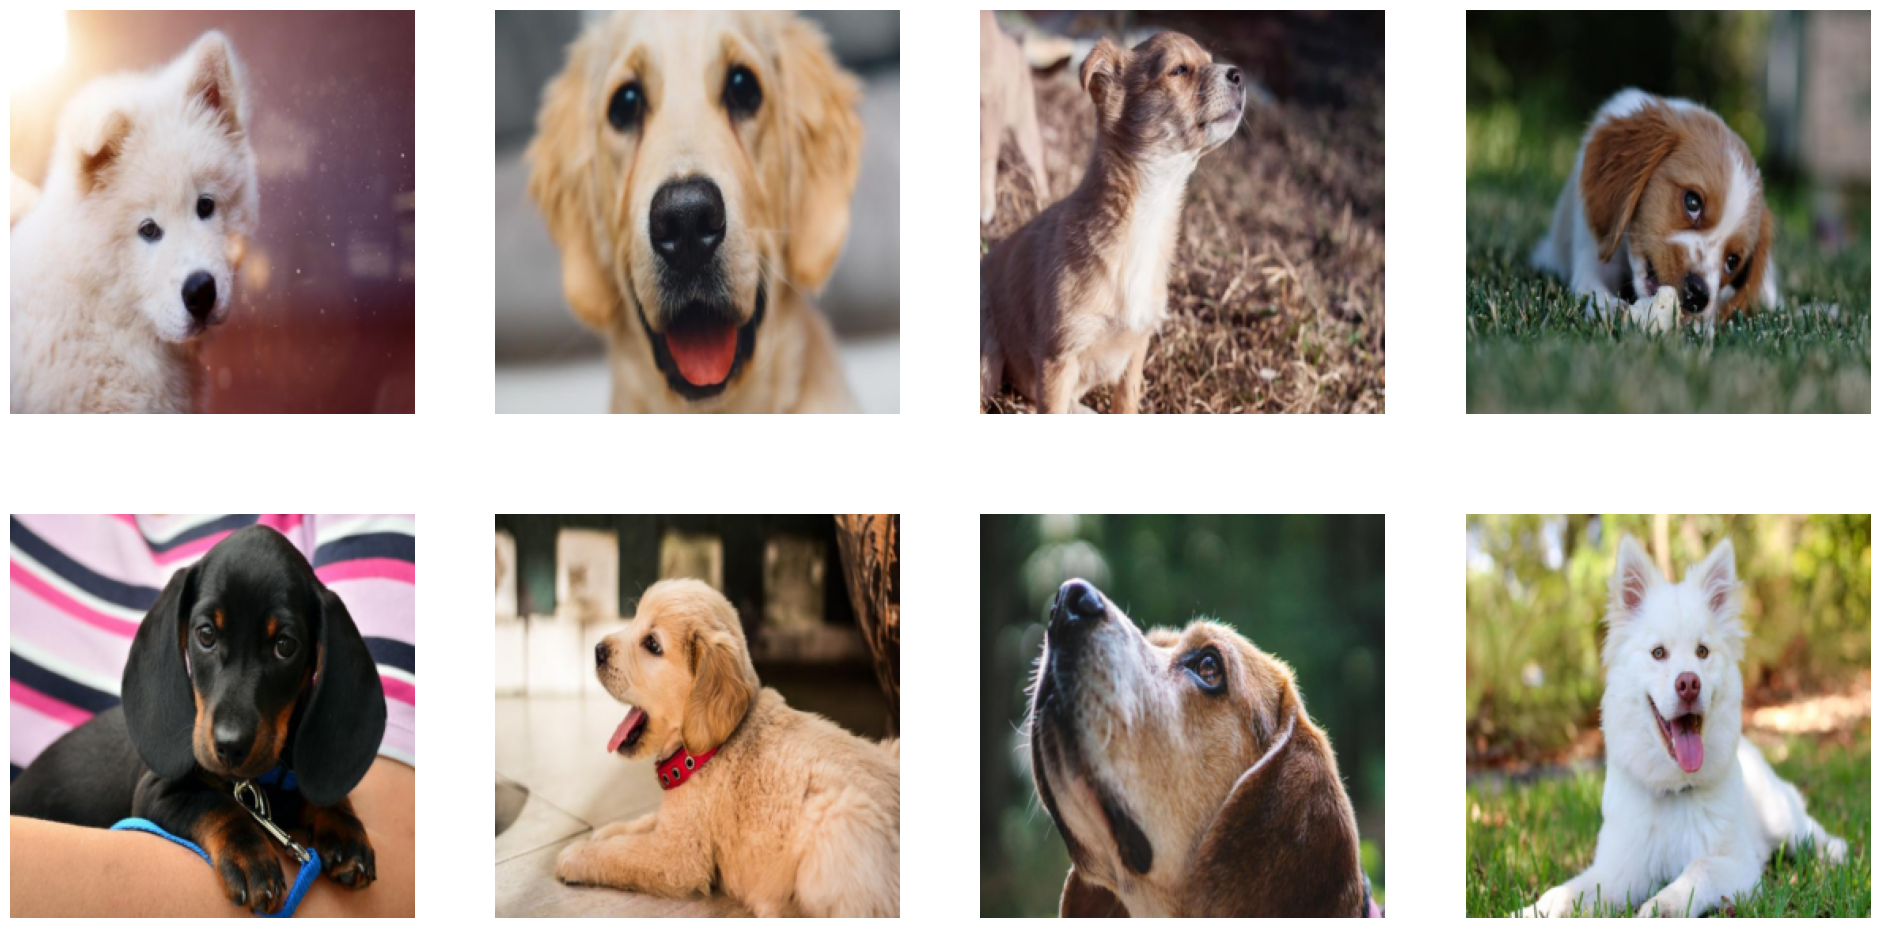

In [16]:
show_image(batch["images"])

### GPU acceleration

For now the preprocessing was using only the CPU even though we passed the `device_id=0`.  Note the backend of the output JAX arrays:

In [17]:
print(f'Images backing device: {batch["images"].device()}')

Images backing device: TFRT_CPU_0


One of the main features that DALI offers is the ability to run the preprocessing on the GPU. For our simple example let's run the image resizing on the GPU. The only change required to do it is to move the decoded images to the GPU. We can do it using `gpu` method. Resize will recognize that its input is on the GPU and will execute the operation on the GPU as well.

In [18]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs)
    images = images.gpu()
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels

iterator = iterator_fn(batch_size=8)

We see that `images` is backed by the GPU now.

As mentioned before, decorating the function with `data_iterator` adds some arguments to it. We discussed `batch_size` already. Two other that might be useful are:
 - `device_id` - used to control which GPU will be used to execute computations,
 - `num_threads` - used to control the number of CPU threads that will be used to execute the pipeline,

In [19]:
iterator = iterator_fn(batch_size=1, device_id=1, num_threads=2)

batch = next(iterator)
print(f'Images backing device: {batch["images"].device()}')

Images backing device: cuda:1


Note how the backing device for the output changed to the GPU with device ID equal to 1.

### Hardware accelerated decoding

Another important feature of DALI is the ability to GPU accelerate JPEG decoding by using nvJPEG and nvJPEG2000 libraries. This is especially useful when you have a lot of high resolution images that need to be decoded. nvJPEG and nvJPEG2000 are designed to take advantage of the GPU hardware acceleratoed decoder to remove this bottleneck. To learn more about them you can take a look at [this developer page](https://developer.nvidia.com/nvjpeg).

Not all aspects of the JPEG decoding process are well suited to be parallelized by using the GPU. The CPU is responsible for handling the sequential part of the decoding. To make use of this hybrid approach, you can set `mixed` as the `device` argument value in the `fn.decoders.image` operator.

After this change the decoded outputs are backed by the GPU so it is no longer necessary to move them to the GPU manually. Updated code looks like this:

In [20]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels

iterator = iterator_fn(batch_size=8)

In [21]:
batch = next(iterator)

print(f'Images backing device: {batch["images"].device()}')
print(f'Labels backing device: {batch["labels"].device()}')

Images backing device: cuda:0
Labels backing device: TFRT_CPU_0


### Random shuffling

One of the requried steps in training is to shuffle the data. DALI provides a way to do it efficiently. We can use the `random_shuffle` argument of the reader to do it. The argument takes a boolean value. If it is set to `True` the data will be shuffled randomly. If it is set to `False` the data will be returned in the order it was read from the storage. To ensure the reproducibility of the results we can also set the `seed` argument to a fixed value:

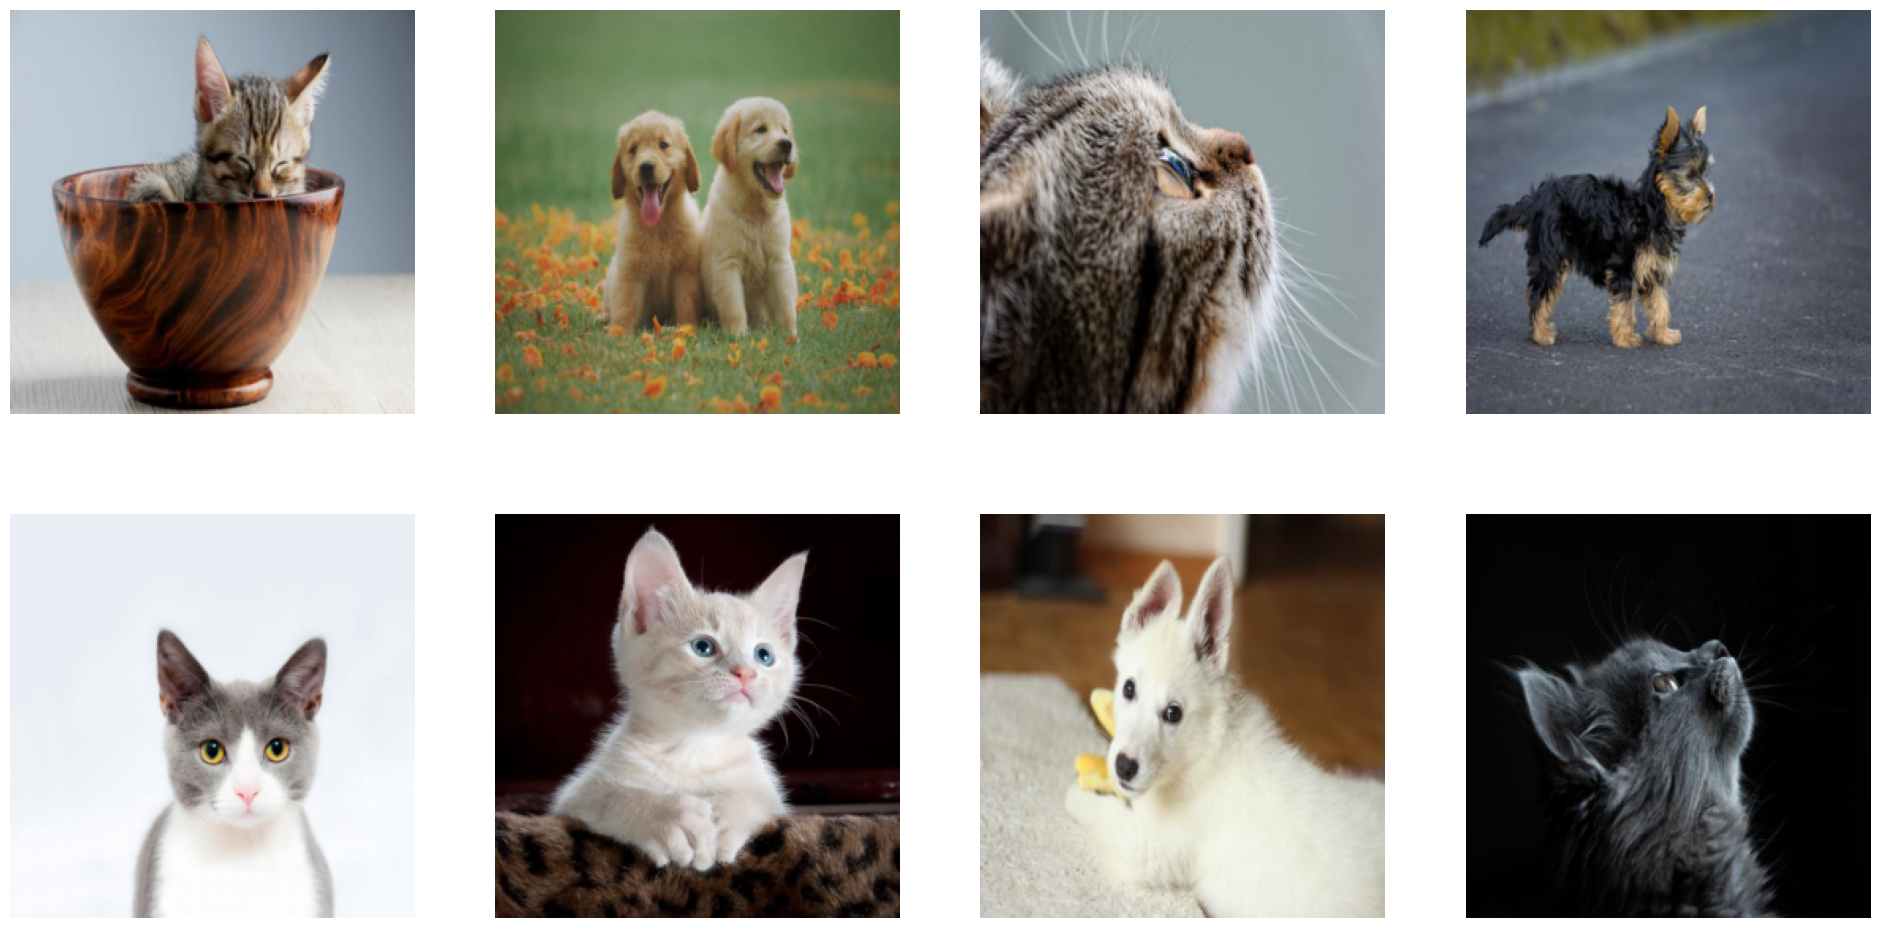

In [23]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader", random_shuffle=True)
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels

iterator = iterator_fn(batch_size=8, seed=0)

batch = next(iterator)
show_image(batch["images"])

### Augmentations

DALI provides a wide range of augmentations that can be used to improve the quality of the training data. To learn more about them you can take a look at [DALI documentation](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/supported_ops.html#supported-ops). In this section we will cover how to use them in JAX workflows. For this simple example we want to apply random rotation to the images. We want to rotate the images by a random angle in the range `[-10, 10]`. To do it we will use `fn.random.uniform` to generate random angles and `fn.deformations.rotate` to perform the rotation.

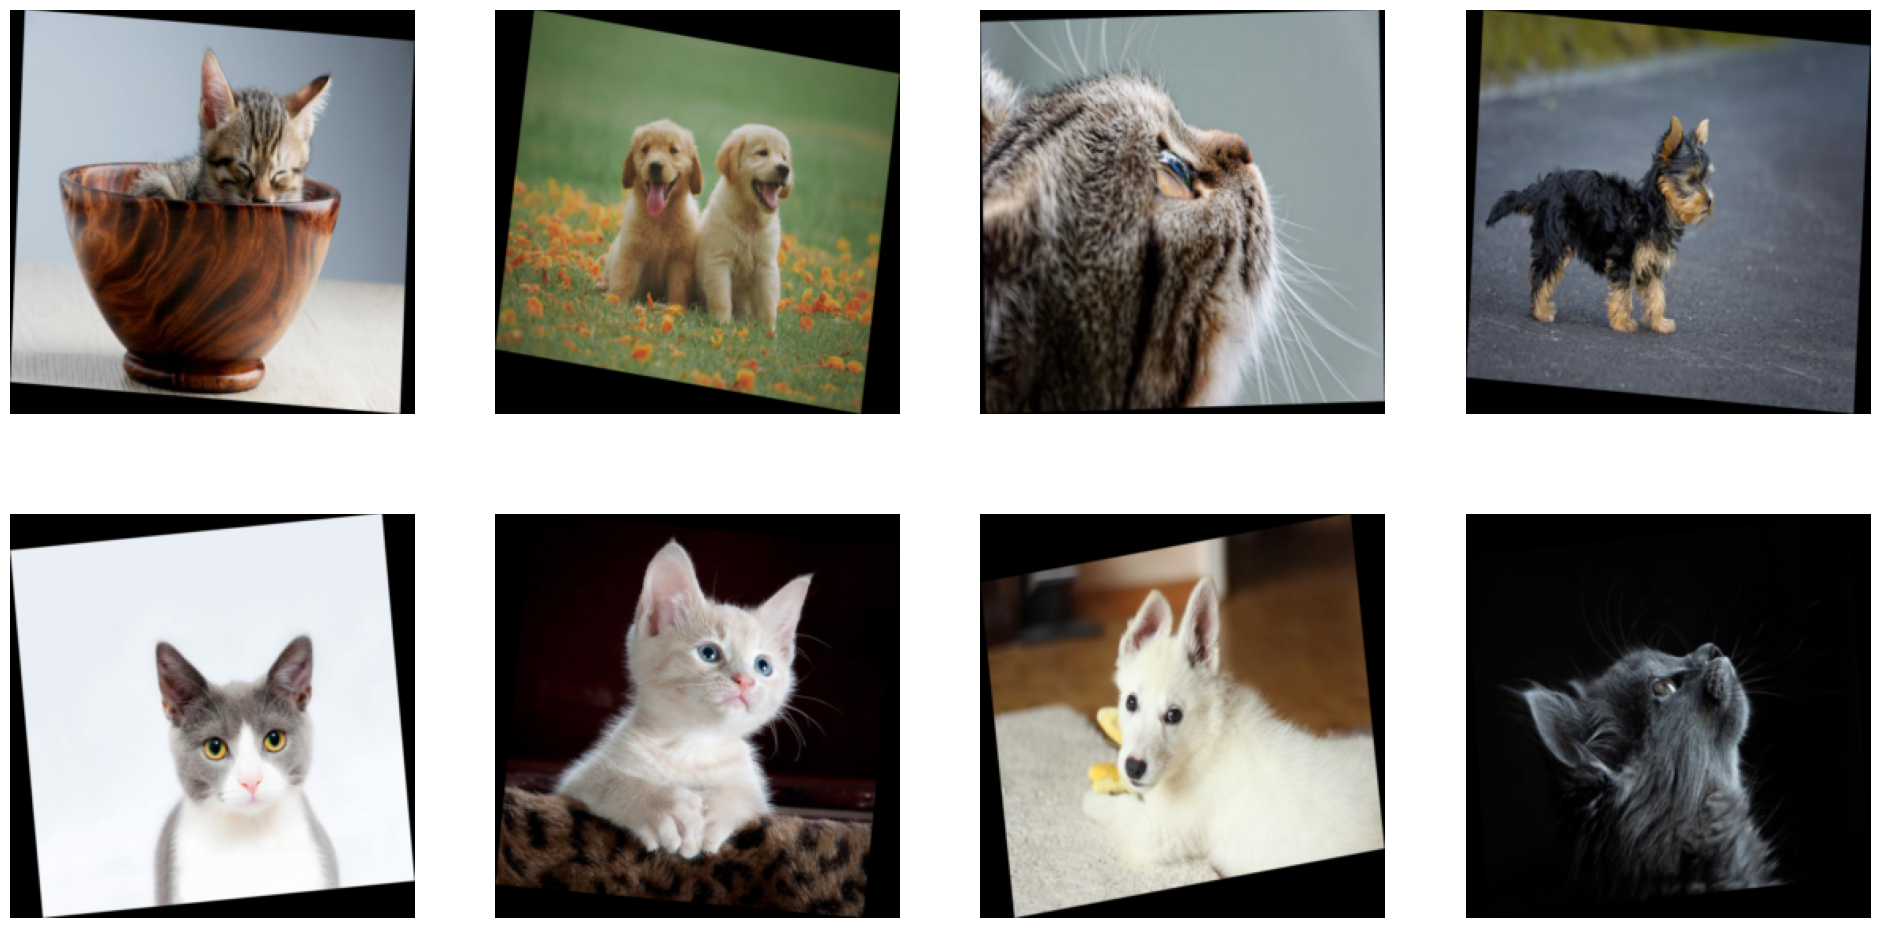

In [24]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader", random_shuffle=True)
    images = fn.decoders.image(jpegs, device="mixed")
    angle = fn.random.uniform(range=(-10.0, 10.0))
    images = fn.rotate(images, angle=angle, fill_value=0)
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels

iterator = iterator_fn(batch_size=8, seed=0)

batch = next(iterator)
show_image(batch["images"])

### Multiple GPUs

One of the strenghts of JAX is the ability to scale up the training to multiple GPUs very easily. DALI provides a simple way to do it as well that is compatible with JAX scale up mechanism. `data_iterator` decorator accepts `sharding` argument. We can pass the same value that is used to scale up other computations in JAX.

Let's assume that in a JAX workflow we want to parallelize the computations across multiple GPUs along the batch dimension. One of the ways to accomplish this is with `NamedSharding`. It is a simple way to express the sharding pattern. It maps the dimension names to the list of devices that will be used to execute computations along this dimension. In our case we want to shard along the dimension that we name "batch" to communicate what it represents. We want to use all available GPUs to execute computations along this dimension. We can use `jax.local_devices()` to get the list of available devices. The code looks like this:

In [25]:
import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding

mesh = Mesh(jax.devices(), axis_names=('batch'))
sharding = NamedSharding(mesh, PartitionSpec('batch'))

print(sharding)

NamedSharding(mesh=Mesh('batch': 2), spec=PartitionSpec('batch',))


We want DALI iterator to return outputs compatible with this sharding pattern. We can do it by passing the `sharding` argument to the `data_iterator` decorator.

One modification needed in the decorated function is an introduction of `num_shards` and `shard_id` arguments. They can be used to pass the information about sharding to the reader. It will read only the part of the dataset that is assigned to the current shard. To learn more about DALI sharding mechanism look into [DALI sharding doc](https://docs.nvidia.com/deeplearning/dali/archives/dali_1_30_0/user-guide/docs/examples/general/multigpu.html#Sharding).

In [26]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader")
def iterator_fn(num_shards=1, shard_id=0):
    jpegs, labels = fn.readers.file(
        file_root=image_dir, name="image_reader", num_shards=num_shards, shard_id=shard_id)
    images = fn.decoders.image(jpegs, device="mixed")
    angle = fn.random.uniform(range=(-10.0, 10.0))
    images = fn.rotate(images, angle=angle, fill_value=0)
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels.gpu()

Default values of `num_shards` and `shard_id` set above are the same as the dafault values for these arguments in `fn.reader.file`. In this configuration there is no sharding - reader will read the whole dataset and there will be only one shard with `shard_id == 0`. When we pass `sharding` to the decorator these arguments will be set automatically to appropriate values. 

Now we are ready to scale up the `iterator_fn` to multiple GPUs. Note the addition of `sharding` argumnet to the decorator:

In [27]:
@data_iterator(output_map=["images", "labels"], reader_name="image_reader", sharding=sharding)
def iterator_fn(num_shards=1, shard_id=0):
    jpegs, labels = fn.readers.file(
        file_root=image_dir, name="image_reader", num_shards=num_shards, shard_id=shard_id)
    images = fn.decoders.image(jpegs, device="mixed")
    angle = fn.random.uniform(range=(-10.0, 10.0))
    images = fn.rotate(images, angle=angle, fill_value=0)
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels.gpu()

In this setup we want to spread the preprocessing computations across multiple GPUs. We no longer need to pass the `device_id`. It is set automatically based on the `sharding`. In runtime we will have multiple instances of the pipeline running on different GPUs. Each of them will read a different part of the dataset. Iterator will get outputs from all the pipelines and will build a batch from them. The batch will be sharded along the "batch" dimension. The sharding pattern will be compatible with the sharding pattern used in the rest of the JAX workflow.

In [28]:
iterator = iterator_fn(batch_size=8)

In [29]:
batch = next(iterator)
images = batch["images"]

print(f'Images shape: {images.shape}')
print(f'Images backing device: {images.devices()}')
print(f'Images sharding: {images.sharding}')

Images shape: (8, 256, 256, 3)
Images backing device: {cuda(id=1), cuda(id=0)}
Images sharding: NamedSharding(mesh=Mesh('batch': 2), spec=PartitionSpec('batch',))


We can use `visualise_array_sharding` from JAX to visualize how the data is distributed across the GPUs.

In [30]:
jax.debug.visualize_array_sharding(images.ravel())

  GPU 0    GPU 1  
                  

We can further look into the content of the batch to see how the data is distributed across the GPUs. We can see that the first half of the batch is on the first GPU and the second half is on the second GPU:

In [31]:
print(f'Shard 0 device: {images.device_buffers[0].device()}, shape: {images.device_buffers[0].shape}')
print(f'Shard 1 device: {images.device_buffers[1].device()}, shape: {images.device_buffers[1].shape}')

Shard 0 device: cuda:0, shape: (4, 256, 256, 3)
Shard 1 device: cuda:1, shape: (4, 256, 256, 3)


Even though the data is distributed across multiple GPUs, we can still use the `show_image` function to visualize it. It will automatically collect the data from all the GPUs:

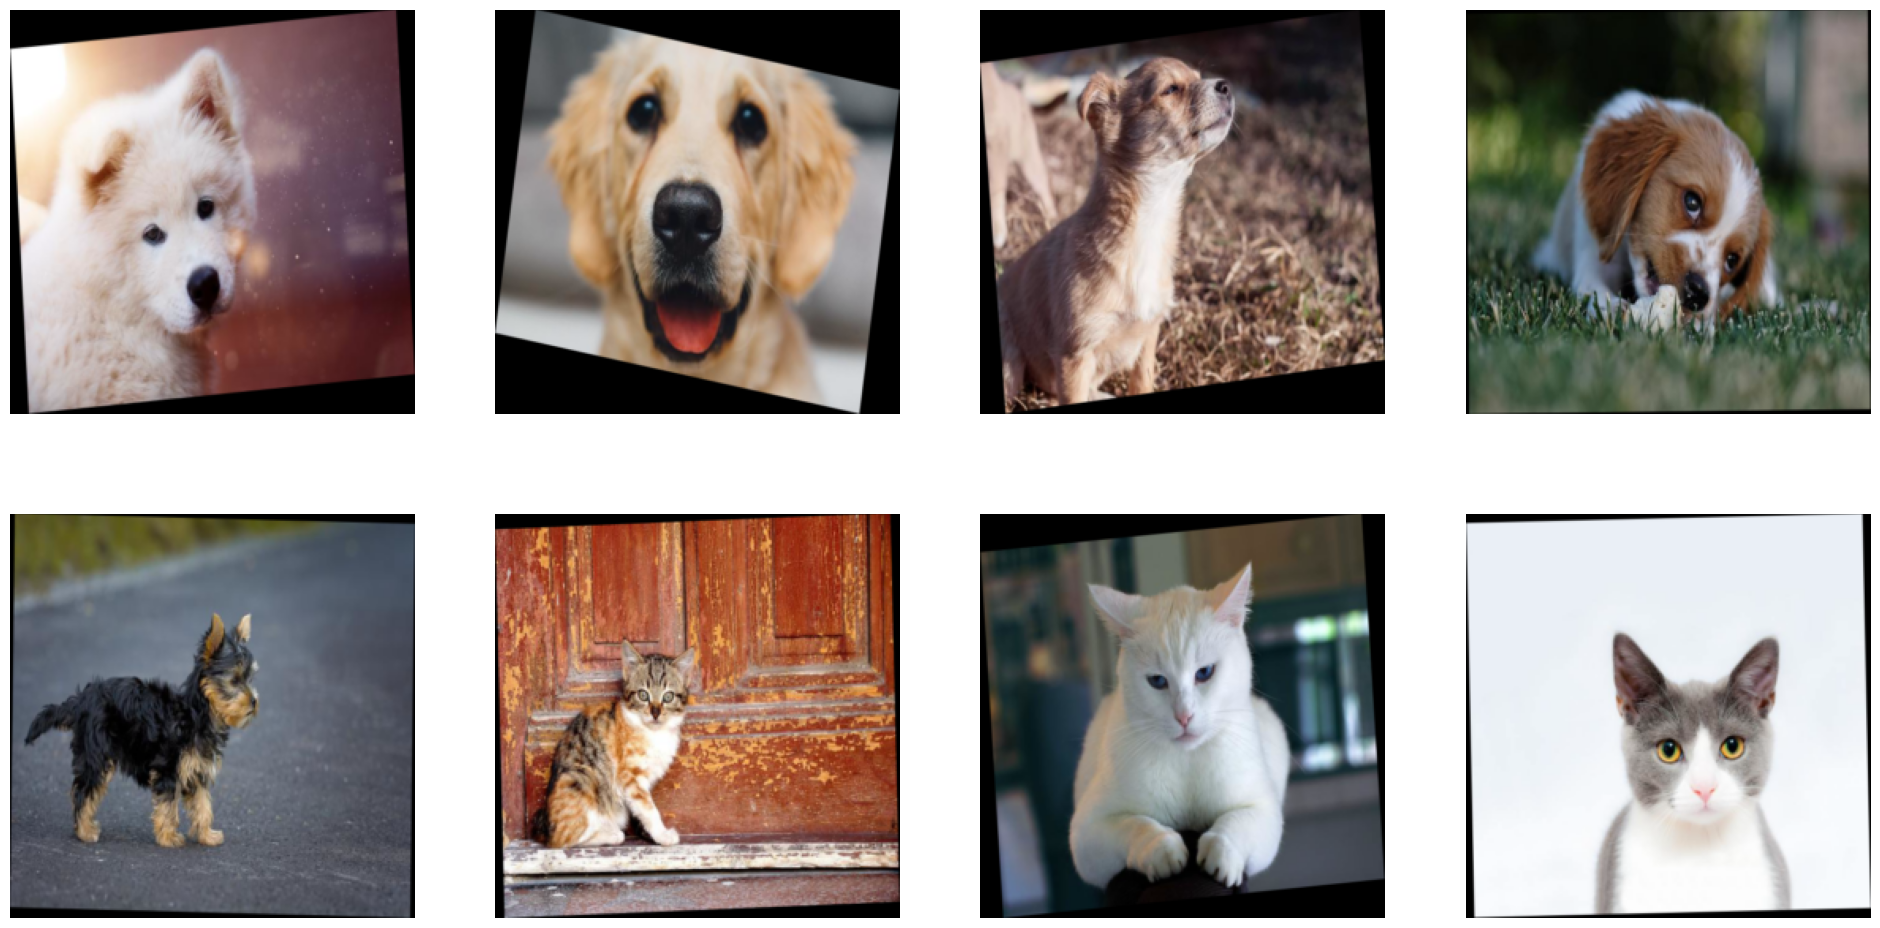

In [32]:
show_image(batch["images"])

### Technical details

This section dives deeper into the technical aspects of the functionalities used in this tutorial, providing a more comprehensive understanding of the tools and concepts employed. First, lets look at the type of the iterator:

In [33]:
print(type(iterator))

<class 'nvidia.dali.plugin.jax.iterator.DALIGenericIterator'>


`DALIGenericIterator` is a high-level interface that simplifies the integration of DALI pipelines with machine learning frameworks. It is a wrapper for DALI pipeline objects that is compatible with JAX. DALI pipeline and iterator can be created manually without the `data_iterator` decorator. Let's go back to the original pipeline definition. We can create a pipeline object and later use this object to create an iterator:

In [34]:
from nvidia.dali.pipeline import pipeline_def

@pipeline_def
def simple_pipeline():
    jpegs, labels = fn.readers.file(file_root=image_dir, name="image_reader")
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, resize_x=256, resize_y=256)
    return images, labels

pipeline = simple_pipeline(batch_size=8, num_threads=1, device_id=0)

print(type(pipeline))

<class 'nvidia.dali.pipeline.Pipeline'>


With the pipeline object we create an iterator:

In [35]:
from nvidia.dali.plugin.jax import DALIGenericIterator

iterator = DALIGenericIterator(pipeline, output_map=["images", "labels"], reader_name="image_reader")

print(type(iterator))

<class 'nvidia.dali.plugin.jax.iterator.DALIGenericIterator'>


Iterator created this way is the same as the one ceated with the `data_iterator` decorator. We can use it to get data the same way:

In [36]:
batch = next(iterator)

print(f'Images backing device: {batch["images"].device()}')
print(f'Labels backing device: {batch["labels"].device()}')

Images backing device: cuda:0
Labels backing device: TFRT_CPU_0


### Where to go next

Congratulations, you learned how to integrate DALI with JAX to efficiently process and augment your data for machine learning workflows. With this foundation, you can explore more advanced topics and enhance your knowledge further:
 - to continue learning about DALI and JAX you can visit [related section of DALI documentation](https://docs.nvidia.com/deeplearning/dali/archives/dali_1_30_0/user-guide/docs/examples/frameworks/jax/index.html). It containes more detailed information and end-to-end training examples for DALI and JAX including libraries from JAX ecosystem like Flax, T5X and Pax.
 - to find out more about DALI in general you can visit [DALI documentation](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html). It contains detailed information about all the features of DALI.
 - if you have any questions about DALI you can visit [DALI Github page](https://github.com/NVIDIA/DALI) and create an issue. We will be happy to hear from you.
 - if you prefere video content we have a curated list of [video materials about DALI](https://github.com/NVIDIA/DALI#additional-resources).